In [254]:
#import
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import variable
from IPython.display import Image

import seaborn


seaborn.set_context('talk')
%matplotlib inline

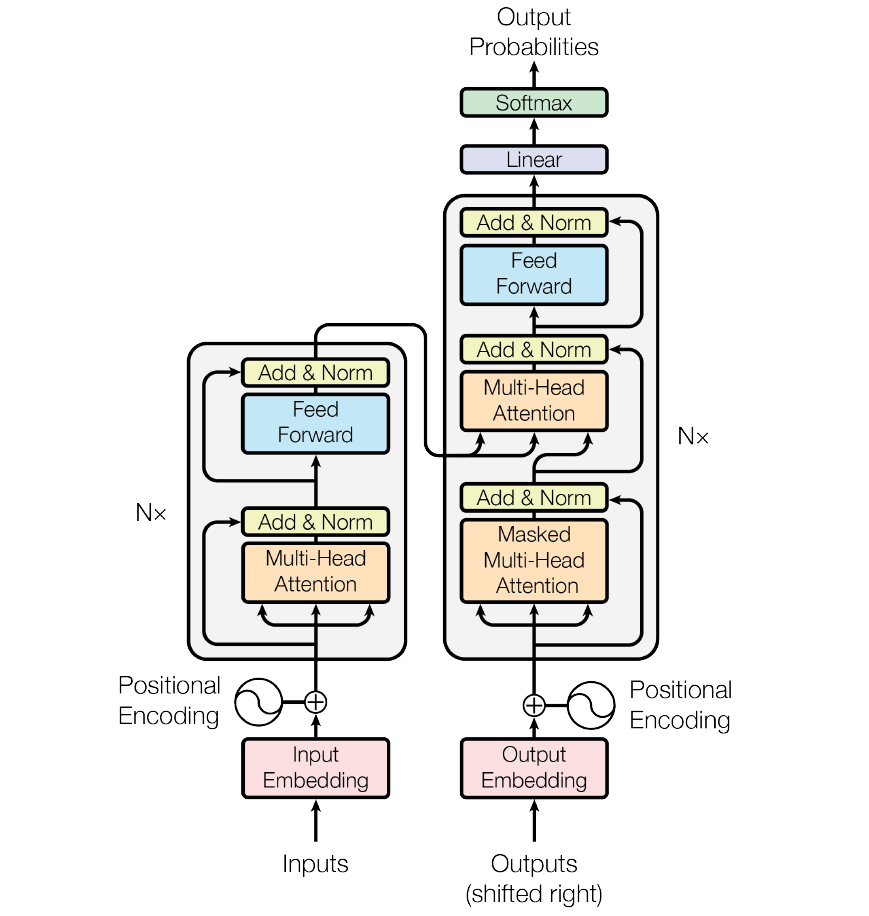

In [255]:
Image(filename='transformer.png')

In [256]:
'''
the may body structure of the transformer
encoder get a input sequence : (x1, x2,...,xn) -> (z1,z2,z...zn)

decoder get the sequence : (z1,z2,z...zn) and based on each element, generate a output sequence(y1,y2,...,yn)
'''
class EncoderDecoder(nn.Module):
    #structure of encoder-decoder
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator



    def encode(self, src,src_mask):
        return self.encoder(self.src_embed(src),src_mask) # embeeding and mask

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt),memory,src_mask,tgt_mask)

    def forward(self, src, tgt,src_mask, tgt_mask):
        # process masked src and target sequence
        print(f"Model receive src shape: {src.shape}, type: {src.dtype}")
        print(f"Model receive tgt shape: {tgt.shape}, type: {tgt.dtype}")
        o = self.decode(self.encode(src,src_mask),src_mask,tgt,tgt_mask)
        print(f"Model output shape: {o.shape}, type: {o.dtype}")
        return o


In [257]:
# the upper right side part
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [258]:
# method clone generate exatly same layer N times
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [259]:

#entire Encoders = N* encoder Layer, and finally we normalized it once
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
       # print(f"encoder receive x shape: {x.shape}, type: {x.dtype}")
        for layer in self.layers:
            x = layer(x, mask)
        o = self.norm(x)
       # print(f"Encoder output shape: {o.shape}, type x: {o.dtype}")
        return o


In [260]:
# either from torch.nn import LayerNorm
# in the encoder contain self attention sublayer or FFNN sublayer; the x add&norm the output of each layer
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        #print(f"LayerNorm input shape: {x.shape}")
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [261]:
#sublayer finnal output should be LayerNorm(x + sublayer(x)) also implement a dropout
#for easy to connecting, all layer and embedding have same output dim = 512
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection,self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm(size)
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [262]:
# finally each entire layer encoder self-attention + FFNN connected by sublayerConnection:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout, *args, **kwargs):
        super(EncoderLayer,self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2) # generate 2 connector; one connect to output of self-attention; another connect to FFNN
        self.size = size

    def forward(self, x, mask):
       # print(f"EncoderLayer input shape: {x.shape}, type x: {x.dtype}")
        x = self.sublayer[0](x = x, sublayer = lambda x: self.self_attn(x,x,x, mask))
        o = self.sublayer[1](x,self.feed_forward)
       # print(f"EncoderLayer output shape: {o.shape}, type x: {o.dtype}")
        return o


In [263]:
'''Decoder
same way, decoder also contain N=6 layer

'''
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [292]:
'''
In each decoderLyaer; we have 3 sublayers
1. self attention
2. attention to the output of encoder(query message(q) is from self-attention, key message(k) and Value(V) is from encoder
3. FFNN
'''
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn,src_attn, feed_forward, dropout):
        super(DecoderLayer,self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # from the figure yellow part [add&norm] in the decoder, we have 3 connector
        self.size = size

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x,m,m,src_mask)) # the output from the encoder finnaly become m (z1, z2,... , zn)
        return self.sublayer[2](x, self.feed_forward)




In [265]:
# for the self attention layer in Decoder; we want it only attention on the previous information, so we need mask the future
def subsequent_mask(size):
    #mask out subsequence based on position
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

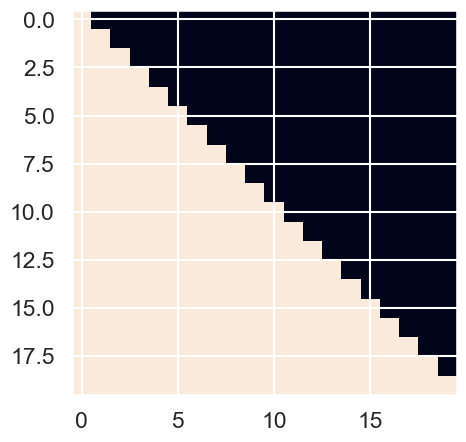

In [266]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])


In [267]:
'''Attention
Attention(Q,K,V) = softmax(Q*K'/sqrt(N))V
'''
def attention(Q,K,V, mask = None, dropout = None):

    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, V), p_attn

In [268]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, q, k, v, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = q.size(0)

        # do all the linear projections in batch from d_model => h x d_k

        q, k, v = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (q, k,v))
            ]
        x, self.attn = attention(q,k,v,mask=mask,dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


In [269]:
'''FFNN
 feedforward layer is on the last part of each layer of encoder or decoder; it contain two linear and one relu active fucntion

 FFN(x) = relu(xW1 + b1) W2 + b2
'''
# where is b1 and b2??
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [270]:
'''the rest part of the tranfsormer:
embedding
position coding
'''
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        print(f"Before Embedding, shape: {x.shape}")
        embedded = self.lut(x)*math.sqrt(self.d_model)
        print(f"Before Embedding, shape: {embedded.shape}")
        return embedded

In [271]:
#position encoding:
#generate a matrix that show
# PE(pos,2i) = sin(pos/100000^2i/d)
# ; PE(pos,2i+1) = cos(pos/100000^2i/d)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model,dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)
        return self.dropout(x)


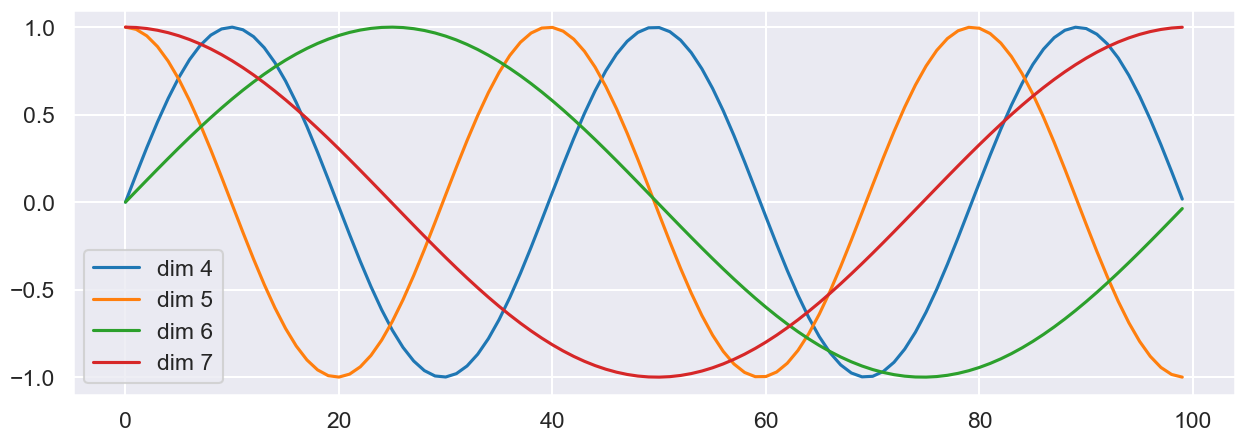

In [272]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [273]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn),
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [274]:
tmp_model = make_model(10, 10, 2)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (dropout): Dropout(p=0.1, inplace=False)
            (norm): LayerNorm()
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

In [275]:
'''
Now we built the model; based on the model size we can pre-process the data into batch and build a train- optimize low
'''
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)  # Encoder mask (pad masking)

        if trg is not None:
            self.trg = trg  # Keep the original length, no slicing!
            self.trg_y = trg[:, 1:]  # Shift left for training labels
            self.trg_mask = self.make_std_mask(self.trg, pad)  # Apply look-ahead mask
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)  # Padding mask
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)  # Look-ahead mask
        return tgt_mask


In [293]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask


In [277]:
global max_src_in_batch, max_trg_in_batch
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_trg_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_trg_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_trg_in_batch = max(max_trg_in_batch, len(new.trg)+2)
    src_elements = count * max_src_in_batch
    trg_elements = count * max_trg_in_batch
    return max(src_elements, trg_elements)

In [278]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

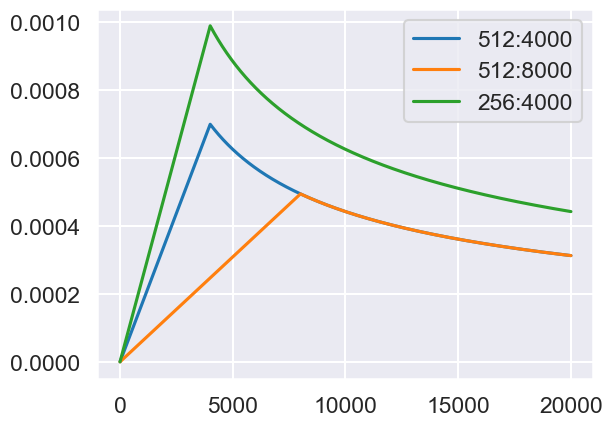

In [279]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [280]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist)

D:\anaconda\envs\d2l\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


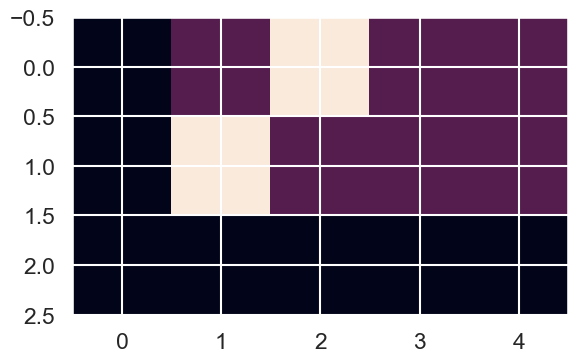

In [281]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(predict.log(),
         torch.LongTensor([2, 1, 0]))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [282]:
print(crit.true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [283]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task with the same length."
    for _ in range(nbatches):
        data = torch.randint(1, V, (batch, 10), dtype=torch.long)
        data[:,0] = 1
        src = data
        tgt = data
        yield Batch(src, tgt, 0)


In [284]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [294]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model,
                    SimpleLossCompute(model.generator, criterion, None)))

batch src shape: torch.Size([30, 10]), batch trg shape: torch.Size([30, 9])
Model receive src shape: torch.Size([30, 10]), type: torch.int64
Model receive tgt shape: torch.Size([30, 9]), type: torch.int64
Before Embedding, shape: torch.Size([30, 10])
Before Embedding, shape: torch.Size([30, 10, 512])
Before Embedding, shape: torch.Size([30, 9])
Before Embedding, shape: torch.Size([30, 9, 512])
Model output shape: torch.Size([30, 9, 512]), type: torch.float32
batch src shape: torch.Size([30, 10]), batch trg shape: torch.Size([30, 9])
Model receive src shape: torch.Size([30, 10]), type: torch.int64
Model receive tgt shape: torch.Size([30, 9]), type: torch.int64
Before Embedding, shape: torch.Size([30, 10])
Before Embedding, shape: torch.Size([30, 10, 512])
Before Embedding, shape: torch.Size([30, 9])
Before Embedding, shape: torch.Size([30, 9, 512])
Model output shape: torch.Size([30, 9, 512]), type: torch.float32
Epoch Step: 1 Loss: 3.270518 Tokens per Sec: 1553.862671
batch src shape: 

In [297]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           ys,
                           subsequent_mask(ys.size(1)).type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
src_mask = torch.ones(1, 1, 10)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))



model.eval()
src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
src_mask = torch.ones(1, 1, 10)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

Before Embedding, shape: torch.Size([1, 10])
Before Embedding, shape: torch.Size([1, 10, 512])
Before Embedding, shape: torch.Size([1, 1])
Before Embedding, shape: torch.Size([1, 1, 512])
Before Embedding, shape: torch.Size([1, 2])
Before Embedding, shape: torch.Size([1, 2, 512])
Before Embedding, shape: torch.Size([1, 3])
Before Embedding, shape: torch.Size([1, 3, 512])
Before Embedding, shape: torch.Size([1, 4])
Before Embedding, shape: torch.Size([1, 4, 512])
Before Embedding, shape: torch.Size([1, 5])
Before Embedding, shape: torch.Size([1, 5, 512])
Before Embedding, shape: torch.Size([1, 6])
Before Embedding, shape: torch.Size([1, 6, 512])
Before Embedding, shape: torch.Size([1, 7])
Before Embedding, shape: torch.Size([1, 7, 512])
Before Embedding, shape: torch.Size([1, 8])
Before Embedding, shape: torch.Size([1, 8, 512])
Before Embedding, shape: torch.Size([1, 9])
Before Embedding, shape: torch.Size([1, 9, 512])
tensor([[ 1,  2,  3,  3,  5,  6,  7,  8,  9, 10]])
Before Embedding,